KNN으로 전처리->모델링->평가

메모장이나 편집화면으로 볼 것!

1. 로지스틱 리그레션
train
정확도: 0.8612268080272624
재현율: 0.7125534950071327
정밀도: 0.7516930022573364
F1 점수: 0.7316001464664957
Average Precision: 0.8233739105827503
ROC-AUC Score: 0.922151620659735
test
정확도: 0.858603066439523
재현율: 0.6873661670235546
정밀도: 0.7570754716981132
F1 점수: 0.7205387205387206
Average Precision: 0.826315880600229
ROC-AUC Score: 0.9281265203591605

Important Feature
numTechTickets
Contract_Month-to-month
InternetService_Fiber optic
2. 랜덤포레스트
train
정확도: 0.9596743657705414
재현율: 0.9179743223965763
정밀도: 0.9292418772563177
F1 점수: 0.9235737351991389
Average Precision: 0.9752523780322906
ROC-AUC Score: 0.9915207656220127
test
정확도: 0.8512208972174901
재현율: 0.6488222698072805
정밀도: 0.7556109725685786
F1 점수: 0.6981566820276498
Average Precision: 0.8045045641071308
ROC-AUC Score: 0.9169226110296576

Important Feature
numTechTickets
tenure
TotalCharges

3.디시전 트리
train
정확도: 0.8987126088602801
재현율: 0.7624821683309557
정밀도: 0.8410700236034618
F1 점수: 0.799850355405911
Average Precision: 0.9070518581593674
ROC-AUC Score: 0.9642955755400974
test
정확도: 0.8438387279954571
재현율: 0.6702355460385439
정밀도: 0.7211981566820277
F1 점수: 0.6947835738068813
Average Precision: 0.7058679689890119
ROC-AUC Score: 0.8710636143094963

Important Feature
Contract_Month-to-month
numTechTickets
tenure

4.SVM
train
정확도: 0.857061719045816
재현율: 0.702567760342368
정밀도: 0.7445200302343159
F1 점수: 0.7229357798165138
Average Precision: 0.8156656303234376
ROC-AUC Score: 0.9203777372531141
test
정확도: 0.8642816581487791
재현율: 0.69593147751606
정밀도: 0.7701421800947867
F1 점수: 0.7311586051743532
Average Precision: 0.8301595390922609
ROC-AUC Score: 0.9259587157329663

Important Feature
numTechTickets
tenure
TotalCharges

5. XGboost
train
정확도: 0.8871639530480878
재현율: 0.7553495007132668
정밀도: 0.8071646341463414
F1 점수: 0.7803979366249079
Average Precision: 0.8938230815095652
ROC-AUC Score: 0.9539816094827713
test
정확도: 0.8625780806360023
재현율: 0.6809421841541756
정밀도: 0.7737226277372263
F1 점수: 0.724373576309795
Average Precision: 0.8349934459151099
ROC-AUC Score: 0.9320136753720847

Important Feature
Contract_Month-to-month
InternetService_Fiber optic
OnlineSecurity_No


1. 원핫인코딩 후 logistic regression. y는 label-encoding

In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [119]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
column_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", LogisticRegression(random_state=42, C=1)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "model__C": [0.05, 0.06, 0.07, 0.08, 0.09],
    "model__penalty":['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100,200,300,400,500]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="f1", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.05, 0.06, ...], 'model__max_iter': [100, 200, ...], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear', 'saga']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [121]:
print(gs.best_score_, gs.best_params_)

0.7298844528577415 {'model__C': 0.07, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'saga'}


In [122]:
# 평가
pred_train = gs.predict(X_train)
pred_test = gs.predict(X_test)

pred_train_proba = gs.predict_proba(X_train)
pred_test_proba = gs.predict_proba(X_test)

In [123]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.8612268080272624
재현율: 0.7125534950071327
정밀도: 0.7516930022573364
F1 점수: 0.7316001464664957
Average Precision: 0.8233739105827503
ROC-AUC Score: 0.922151620659735
test
정확도: 0.858603066439523
재현율: 0.6873661670235546
정밀도: 0.7570754716981132
F1 점수: 0.7205387205387206
Average Precision: 0.826315880600229
ROC-AUC Score: 0.9281265203591605


-1.5207168201917738


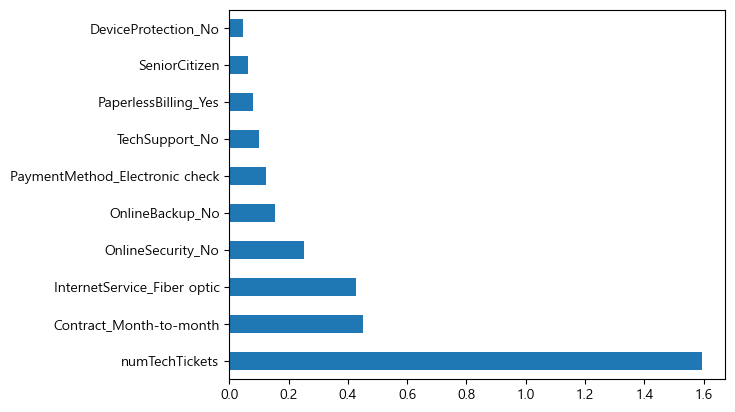

In [124]:
# 회귀 계수 확인
# coefficients = pipeline['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용
coefficients = gs.best_estimator_['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용

# 피처 이름과 계수 매핑
coef_series = pd.Series(coefficients, index=column_names)

print(coef_series.loc['tenure'])
# 결과 출력 (계수 값 기준 정렬 등)
coef_series.sort_values(ascending=False)[:10].plot(kind="barh");


이 위까지 one-hot encoding 후 linear regression

2. Randomforest

In [125]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [126]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
randomforest_feature_name = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("model", RandomForestClassifier(max_depth=16, random_state=42) )
])

params = {
    "model__max_depth": [11, 12, 13],
    "model__n_estimators": [90, 100, 110],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 3, 5]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="f1", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [11, 12, ...], 'model__min_samples_leaf': [1, 3, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [90, 100, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [128]:
print(gs.best_score_)
print(gs.best_params_)

0.7098325747140926
{'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [129]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [130]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.9596743657705414
재현율: 0.9179743223965763
정밀도: 0.9292418772563177
F1 점수: 0.9235737351991389
Average Precision: 0.9752523780322906
ROC-AUC Score: 0.9915207656220127
test
정확도: 0.8512208972174901
재현율: 0.6488222698072805
정밀도: 0.7556109725685786
F1 점수: 0.6981566820276498
Average Precision: 0.8045045641071308
ROC-AUC Score: 0.9169226110296576


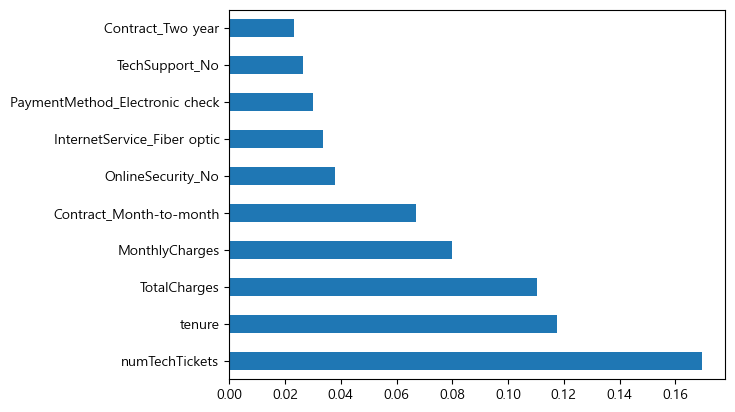

In [131]:
randomforest_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=randomforest_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");


여기까지 원핫인코딩 후 randomforest. y는 label

3. decision tree

In [132]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [133]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
decision_feature_name = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ("model", DecisionTreeClassifier(max_depth=8, random_state=42) )
])

params = {
    "model__max_depth": [13, 14, 15],
    "model__min_samples_split": [2, 3],
    "model__min_samples_leaf": [4, 7, 8, 9]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="f1", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [13, 14, ...], 'model__min_samples_leaf': [4, 7, ...], 'model__min_samples_split': [2, 3]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [135]:
print(gs.best_score_)
print(gs.best_params_)

0.6844173986793992
{'model__max_depth': 14, 'model__min_samples_leaf': 9, 'model__min_samples_split': 2}


In [136]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [137]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.89568345323741
재현율: 0.753922967189729
정밀도: 0.8368962787015044
F1 점수: 0.7932457786116323
Average Precision: 0.9032521147077911
ROC-AUC Score: 0.9625203133961792


In [138]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8364565587734242
재현율: 0.6402569593147751
정밀도: 0.7136038186157518
F1 점수: 0.6749435665914221
Average Precision: 0.7165159097429885
ROC-AUC Score: 0.8782943183661042


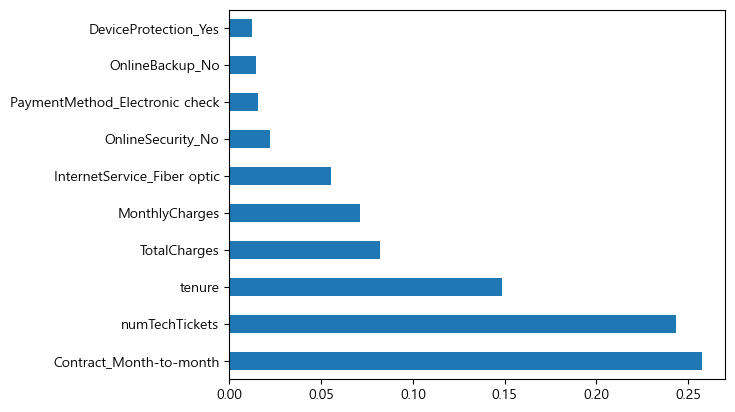

In [139]:
decision_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=decision_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");

4. SVM

In [174]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [175]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SVM : Feature scaling/One Hot Encoding 전처리.
pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm", SVC(random_state=0, probability=True)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "svm__kernel": ["linear", "rbf",  "poly", "sigmoid"],
    "svm__C": [1.2, 1.3, 1.4], 
    "svm__gamma": [0.01, 0.02], 
}

gs = GridSearchCV(
    pipeline, 
    params,
    scoring=["f1", "recall"], 
    refit="f1",
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'svm__C': [1.2, 1.3, ...], 'svm__gamma': [0.01, 0.02], 'svm__kernel': ['linear', 'rbf', ...]}"
,scoring,"['f1', 'recall']"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [177]:
print(gs.best_score_, gs.best_params_)

0.7219471296661344 {'svm__C': 1.3, 'svm__gamma': 0.01, 'svm__kernel': 'linear'}


In [178]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [ ]:
# 모델을 'svm_model.pkl' 파일로 저장
import pickle
filename = '../models/ML/model_dir/XGB_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

FileNotFoundError: [Errno 2] No such file or directory: '../src/models/ML/model_dir/XGB_model.pkl'

In [168]:
from sklearn.metrics import precision_recall_curve
pos_proba_test = gs.best_estimator_.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pos_proba_test)
thresholds = np.append(thresholds, 1)

In [169]:
import pandas as pd
prc_df = pd.DataFrame({
    "threshold":thresholds,
    "recall": recalls,
    "precision": precisions
})
prc_df.set_index('threshold', inplace=True)
prc_df
# threshold가 커지면 precision이 올라가고 recall은 떨어진다.
# threshold가 작아지면 recall이 올라가고 precision은 떨어진다.

,recall,precision
threshold,,
0.000091,1.000000,0.265190
0.000093,1.000000,0.265341
0.000107,1.000000,0.265492
0.000109,1.000000,0.265643
0.000116,1.000000,0.265794
...,...,...
0.992508,0.008565,1.000000
0.993070,0.006424,1.000000
0.996525,0.004283,1.000000


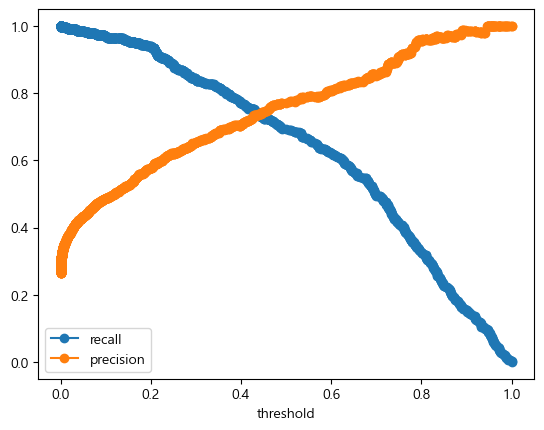

In [170]:
prc_df.plot(marker='o');

In [145]:
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

train
정확도: 0.857061719045816
재현율: 0.702567760342368
정밀도: 0.7445200302343159
F1 점수: 0.7229357798165138
Average Precision: 0.8156656303234376
ROC-AUC Score: 0.9203777372531141
test
정확도: 0.8642816581487791
재현율: 0.69593147751606
정밀도: 0.7701421800947867
F1 점수: 0.7311586051743532
Average Precision: 0.8301595390922609
ROC-AUC Score: 0.9259587157329663


In [146]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    gs.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, scoring='f1'
)

numTechTickets  : 0.224 +/- 0.014
tenure          : 0.174 +/- 0.012
TotalCharges    : 0.039 +/- 0.006
Contract_Two year : 0.026 +/- 0.006
Contract_Month-to-month : 0.021 +/- 0.005
InternetService_Fiber optic : 0.010 +/- 0.011
PaymentMethod_Electronic check : 0.004 +/- 0.004
numAdminTickets : 0.003 +/- 0.001
OnlineBackup_No : 0.002 +/- 0.003
PhoneService_No : 0.002 +/- 0.001
MultipleLines_No phone service : 0.002 +/- 0.001
PhoneService_Yes : 0.002 +/- 0.001
PaymentMethod_Mailed check : 0.001 +/- 0.002
OnlineSecurity_No : 0.001 +/- 0.005
TechSupport_No  : 0.001 +/- 0.002
DeviceProtection_No internet service : 0.001 +/- 0.001
InternetService_No : 0.001 +/- 0.001
OnlineSecurity_No internet service : 0.001 +/- 0.001
StreamingTV_No internet service : 0.001 +/- 0.001
TechSupport_No internet service : 0.001 +/- 0.001
OnlineBackup_No internet service : 0.001 +/- 0.001
StreamingMovies_No internet service : 0.001 +/- 0.001
DeviceProtection_No : 0.000 +/- 0.002
Contract_One year : 0.000 +/- 0.004


C:\Users\Playdata\AppData\Local\Temp\ipykernel_24828\1032942441.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])


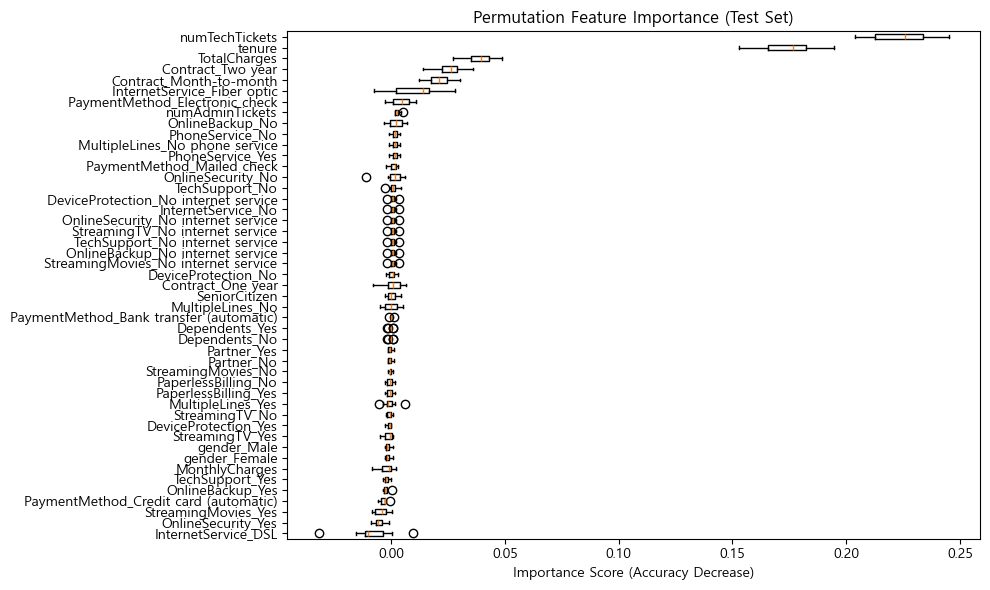

In [147]:
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]: # 내림차순 출력
    print(f"{feature_names[i]:<15} : {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Importance Score (Accuracy Decrease)")
plt.tight_layout()
plt.show()


5. XGboost

In [149]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)

In [150]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
xgb_feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

 GridSearchCV 이용

In [151]:
import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("xgb", XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    "xgb__n_estimators": [300, 400, 500],
    "xgb__learning_rate": [0.03, 0.04, 0.05],
    "xgb__max_depth": [2, 3, 4, 5],
    "xgb__gamma": [0.3, 0.4, 0.5],
    "xgb__scale_pos_weight" : [1,2,3]
}

gs = GridSearchCV(
    pipeline, 
    params,
    scoring=["f1", "recall"], 
    refit="f1",
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__gamma': [0.3, 0.4, ...], 'xgb__learning_rate': [0.03, 0.04, ...], 'xgb__max_depth': [2, 3, ...], 'xgb__n_estimators': [300, 400, ...], ...}"
,scoring,"['f1', 'recall']"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [152]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)
print(gs.best_score_, gs.best_params_)

0.738242252252208 {'xgb__gamma': 0.4, 'xgb__learning_rate': 0.04, 'xgb__max_depth': 3, 'xgb__n_estimators': 400, 'xgb__scale_pos_weight': 2}


train
정확도: 0.8682317304051496
재현율: 0.8659058487874465
정밀도: 0.7049941927990708
F1 점수: 0.7772087067861716
Average Precision: 0.8755866261225139
ROC-AUC Score: 0.9467180537376649
test
정확도: 0.8540601930721181
재현율: 0.8308351177730193
정밀도: 0.6855123674911661
F1 점수: 0.7512100677637947
Average Precision: 0.830808052259304
ROC-AUC Score: 0.9300047327642984


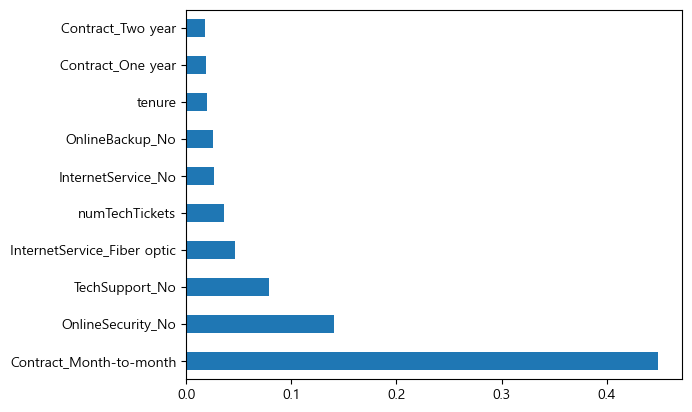

In [153]:
from metrics import print_binary_classification_metrics
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])
importances = gs.best_estimator_['xgb'].feature_importances_
fi = pd.Series(importances, index=xgb_feature_names).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");

optuna로 최적화

In [154]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
xgb_feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [155]:
import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             recall_score, precision_score, f1_score, accuracy_score,
                             PrecisionRecallDisplay, average_precision_score, precision_recall_curve,
                             RocCurveDisplay, roc_auc_score, roc_curve,
                             mean_squared_error, root_mean_squared_error, r2_score)

def objective(trial):
    params = {
        # 탐색할 하이퍼파라미터 범위 정의
        "random_state": 42,
        "max_depth" : trial.suggest_int('max_depth', 4, 6), # 2부터 10까지의 정수
        "n_estimators" : trial.suggest_int('n_estimators', 450, 500), # 50부터 200까지의 정수
        "gamma": trial.suggest_float('gamma', 0.4, 0.5),
        "learning_rate": trial.suggest_float('learning_rate', 0.03, 0.05),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 2, 5)
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds_test = model.predict(X_test)
    return f1_score(y_test, preds_test)

study = optuna.create_study(
    direction="maximize",
    study_name="xgb_opt"
)

study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-11-24 16:31:27,311] A new study created in memory with name: xgb_opt
[I 2025-11-24 16:31:27,569] Trial 0 finished with value: 0.7484333034914951 and parameters: {'max_depth': 6, 'n_estimators': 484, 'gamma': 0.4007753326342083, 'learning_rate': 0.03185478086769414, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.7484333034914951.
[I 2025-11-24 16:31:27,782] Trial 1 finished with value: 0.7429078014184397 and parameters: {'max_depth': 5, 'n_estimators': 450, 'gamma': 0.42074388809457264, 'learning_rate': 0.03358781296175607, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.7484333034914951.
[I 2025-11-24 16:31:27,965] Trial 2 finished with value: 0.7509225092250923 and parameters: {'max_depth': 5, 'n_estimators': 460, 'gamma': 0.4567282854087697, 'learning_rate': 0.04273098368132994, 'scale_pos_weight': 3}. Best is trial 2 with value: 0.7509225092250923.
[I 2025-11-24 16:31:28,121] Trial 3 finished with value: 0.742960944595822 and parameters: {'max_depth': 5, 'n_esti

Best Params: {'max_depth': 5, 'n_estimators': 479, 'gamma': 0.4882054977474665, 'learning_rate': 0.038907813735708896, 'scale_pos_weight': 3}
Best Score: 0.7548566142460684


In [156]:
from optuna.importance import get_param_importances
# 하이퍼파라미터 중요도 계산
param_importances = get_param_importances(study)

print("Parameter Importances:")
for param, importance in param_importances.items():
    print(f"  {param}: {importance:.4f}")

Parameter Importances:
  learning_rate: 0.2807
  gamma: 0.2548
  scale_pos_weight: 0.2324
  n_estimators: 0.2186
  max_depth: 0.0136


train
정확도: 0.8814842862552064
재현율: 0.9450784593437945
정밀도: 0.7070437566702241
F1 점수: 0.8089133089133089
Average Precision: 0.9233619401087332
ROC-AUC Score: 0.9702569598658765
test
정확도: 0.845542305508234
재현율: 0.860813704496788
정밀도: 0.6600985221674877
F1 점수: 0.7472118959107806
Average Precision: 0.8356192764314649
ROC-AUC Score: 0.9301544933129019


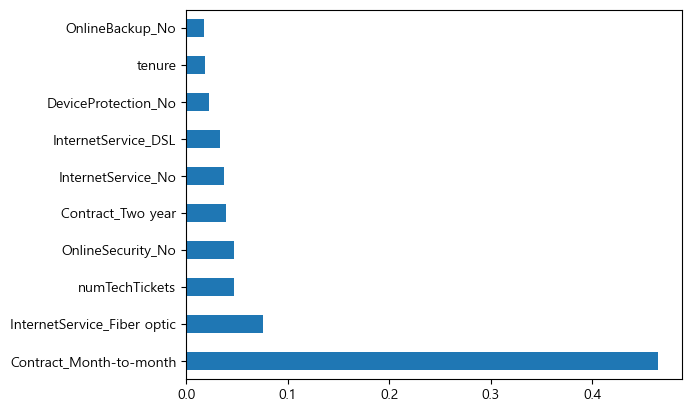

In [157]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('../data/processed/Customer_Churn_Dataset_knn.csv', index_col=0)
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
xgb_feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = XGBClassifier(n_estimators=480, learning_rate=0.038, scale_pos_weight=3, gamma=0.456, max_depth=5, random_state=42)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

pred_train_proba = model.predict_proba(X_train)
pred_test_proba = model.predict_proba(X_test)

from metrics import print_binary_classification_metrics
print("train")
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])
print("test")
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])
importances = model.feature_importances_
fi = pd.Series(importances, index=xgb_feature_names).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");